# First script inversion of the ZNS parameters

Thanks to this script we will carry out an inversion of the parameters of the unsaturated area, the porosity and the depth of the water table in steady state from a valerence simulation sampled in 100 points. The heat transfer takes place in a one-dimensional soil of height 1m represented. 

The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the alpha Van Genuchten parameter $\alpha$,
- the $n$ Van Genuchten parameter, 
- the residual saturation $s_wres$, and
- the water table altitude (WT).


Fill the E_temperature_initiale.dat with the initial temperature profile





# 1 Fill parameters and setup

In [13]:
import os
import numpy as np
from pathlib import Path
import pandas as pd
import array
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import itertools
libs_gfortran = ['gfortran']
# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/sarrebourg/')






In [14]:
def domain_state_time(z_top,z_bottom,dz,dt,state,nb_day,unsat):
    az=abs(z_top-z_bottom)
    # number of cell
    # ## write the parameters
    nb_cell=abs(z_top-z_bottom)/dz
#-----------------------------------------------------------------
    ## write the setup of the moddeled domain
    f_param_bck=open("E_parametre_backup.dat", "r")
    f_param_new = open("E_parametre.dat", 'w')
    setup_model=f_param_bck.read()
    setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
    setup_model=setup_model.replace('[state]','%1i' % state)
    setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
    setup_model=setup_model.replace('[z_top]', '%7.3e' % z_top)
    setup_model=setup_model.replace('[dz]','%6.2e' % dz)
    setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)
    setup_model=setup_model.replace('[unsat]','%1i' % unsat)
    setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
    setup_model=setup_model.replace('[z_bottom]', '%7.3e' % z_bottom)
    setup_model=setup_model.replace('[az]','%7.3e' % az)



    f_param_new.write(setup_model)
    f_param_bck.close()
    f_param_new.close()


    return nb_cell

In [15]:
def geometry(z_top,z_bottom,dz,nb_zone):    
        ########### Zone of parameters
    f_coor=open("E_coordonnee.dat", "w")
    f_zone=open("E_zone.dat", 'w')
    coord=pd.DataFrame()
    # calculate the coordinates to know the number of cell in the domain    
    # Coordinate  
    zvalues =  np.sort(np.arange(z_bottom+dz/2,z_top,dz ))[::-1]

    xvalues = np.array([0.5]) # 1D column
    zz, xx = np.meshgrid(zvalues, xvalues)
    NT = np.prod(zz.shape)
    data = {
        "x": np.reshape(xx,NT),
        "z": np.reshape(zz,NT)}
    coord = pd.DataFrame(data=data)
    coord['id']=coord.index.values.astype(int)
    coord['id']=coord['id']+1
    cols = coord.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    coord = coord[cols] 
    coord.to_csv(f_coor, index = False, sep=' ', header=False)
    #zone parameter by cell ((homogenous domain = 1 zone))
    coord['zone'] =1
    #Pour plusieurs zones modification TH
    # if nb_zone >= 2:
    #     for i in range(2,int(nb_zone)+1):
    #         coord['zone'] = np.where(coord['z'] <= coord.loc[((i-1)*z_top*100/nb_zone),'z'], i,coord['zone'])
            
    
    #coord['zone'] = np.where(coord['z'] <= coord.loc[i-1,'z'], i,coord['zone'])
            #coord['zone'] = np.where(coord['z'] <= thk2, 2,coord['zone'])



    coord.zone.to_csv(f_zone, index=False, header=False)
    
    # close files    
    f_zone.close()
    f_coor.close()
    return coord
    

In [16]:
def initial_boundary_condition(val_WT,itlecture):
    # Initial conditions
    f_IC_bck=open("E_cdt_initiale_backup.dat","r")
    IC_model=f_IC_bck.read()
    IC_model=IC_model.replace('[head_ini]', '%05.2fD+00' % val_WT)

    ## write the boundary conditions
    f_bc_bck=open("E_cdt_aux_limites_backup.dat", "r")
    bc_model=f_bc_bck.read()
    bc_model=bc_model.replace('[top]', '%08.2fD+00' % val_WT)
    bc_model=bc_model.replace('[bot]','%08.2fD+00' % val_WT)
    bc_model=bc_model.replace('[itlecture]', '%8i' % itlecture)   
    f_bc_new = open("E_cdt_aux_limites.dat", 'w')
    f_IC_new=open("E_cdt_initiale.dat","w")
    #Write new ginette files
    f_IC_new.write(IC_model)
    f_bc_new.write(bc_model)
    f_IC_new.close()
    f_IC_bck.close()
    f_bc_bck.close()
    f_bc_new.close()

In [17]:
def parameter_zone_value(val_k,val_n,val_a,val_nVG,val_swres):
    ########### Zone of parameters
    f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
    f_paramZ_new = open("E_zone_parameter.dat", 'w')
    param_zone=f_paramZ_bck.read()
    # replace the parameter values
    param_zone=param_zone.replace('[k1]','%8.2e' % val_k)
    param_zone=param_zone.replace('[n1]','%6.2f' % val_n)
    param_zone=param_zone.replace('[a1]','%8.2e' % val_a)
    param_zone=param_zone.replace('[nVG1]','%6.2f' % val_nVG)
    param_zone=param_zone.replace('[swres1]','%6.2f' % val_swres)
    
    f_paramZ_new.write(param_zone)
    f_paramZ_new.close()
    f_paramZ_bck.close()

## Parametres

In [18]:
#-----------------------------------------------------------------
########### Setup of the model
#name of file boundary condition
name_pluie_file='Pluvio.csv'
name_piezo_file='PZ3.csv'
BC_files="./BC_files/"
#time step in s
dt=86400
#duration of the simulation in days
nb_day=10
# state
## 0 steady state
# 1 transient state (dynamic state)
state=1

# size columnin meter
z_top=20

#altitude column bottom in meter
z_bottom=0

#discretisation : size cell in meter
dz=0.01

#apply unsaturated flow and thermal 
#unsat =1 apply
#unsat=0 cancel unsaturated zone
unsat=1

# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=1
######### PARAMETERS 
#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]
val_k=3.33333333333333e-12
# solid grain density rho_s=val_r  [kg.m-3]
val_r=2578
# porosity
val_n=0.38 # \Phi

# Van Genuchten parameters
val_a=1.50000 #m-1 alpha_vg
val_nVG= 1.8  # n_vg
val_swres=0.1 # S_wr
# Boundary condition water level (meter)
val_WT=0.
itlecture=300

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/ariviere/Programmes/ginette/application/sarrebourg


## 2. files of boundary conditions

In [19]:
# Obtenez la liste des fichiers dans le répertoire
fichiers = os.listdir(BC_files)

info = None
BC_all = None

for fichier in fichiers:
    if fichier.endswith('.csv'):
        if 'PZ' in fichier:
            # read date and float values # #force float values
            all_p = pd.read_csv(os.path.join(BC_files, fichier),decimal='.',sep=',',header=None)
            all_p.rename(columns={all_p.columns[0]: 'dates'}, inplace=True)
            all_p.rename(columns={all_p.columns[1]: 'piezo'}, inplace=True)
            all_p.piezo= all_p.piezo.astype(float)
            all_p['dates']=pd.to_datetime(all_p['dates'],format='%Y-%m-%d %H:%M:%S',errors='coerce')
            print(all_p.dtypes)
        elif 'Pluvio' in fichier:
            all_r = pd.read_csv(os.path.join(BC_files, fichier))
            all_r.rename(columns={all_r.columns[0]: 'dates'}, inplace=True)
            all_r.rename(columns={all_r.columns[1]: 'pluvio'}, inplace=True)
            all_r.rename(columns={all_r.columns[2]: 'cumul'}, inplace=True)
            all_r['dates']=pd.to_datetime(all_r['dates'],format='%d/%m/%Y %H:%M:%S',errors='coerce')
print(all_p.head())
    
BC_all = pd.merge(all_r, all_p, on='dates', how='outer')
print(BC_all['dates'].iloc[0])
print(BC_all.head())

dates    datetime64[ns]
piezo           float64
dtype: object
                dates     piezo
0 2022-12-30 00:00:00 -1.956000
1 2022-12-30 00:05:00 -1.956118
2 2022-12-30 00:10:00 -1.956236
3 2022-12-30 00:15:00 -1.956354
4 2022-12-30 00:20:00 -1.956472
2020-08-01 00:05:00
                dates  pluvio  cumul  piezo
0 2020-08-01 00:05:00     0.0    0.0    NaN
1 2020-08-01 00:10:00     0.0    0.0    NaN
2 2020-08-01 00:15:00     0.0    0.0    NaN
3 2020-08-01 00:20:00     0.0    0.0    NaN
4 2020-08-01 00:25:00     0.0    0.0    NaN


In [20]:

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../src/ginette_V2.f"])  #creat



nb_cell=domain_state_time(z_top,z_bottom,dz,dt,state,nb_day,unsat)
coord=geometry(z_top,z_bottom,dz,nb_zone)
initial_boundary_condition(val_WT,itlecture)
parameter_zone_value(val_k,val_n,val_a,val_nVG,val_swres)
coord.head()


ginette exist


,id,x,z,zone
0,1,0.5,19.995,1
1,2,0.5,19.985,1
2,3,0.5,19.975,1
3,4,0.5,19.965,1
4,5,0.5,19.955,1


## 2. Run the simulation

In [ ]:
# run ginette
subprocess.call(["./ginette"])

# Profile saturation référence au bout de 2 jours

In [9]:
# read the saturation profil   
saturation_profile_REF = pd.read_table('S_saturation_profil_t.dat',delim_whitespace=True,header=None)
saturation_profile_REF.columns=[ "time",  "z","sat"]
saturation_profile_val=saturation_profile_REF.iloc[saturation_profile_REF.index.stop-int(nb_cell):saturation_profile_REF.index.stop]


/tmp/ipykernel_37045/3646361116.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


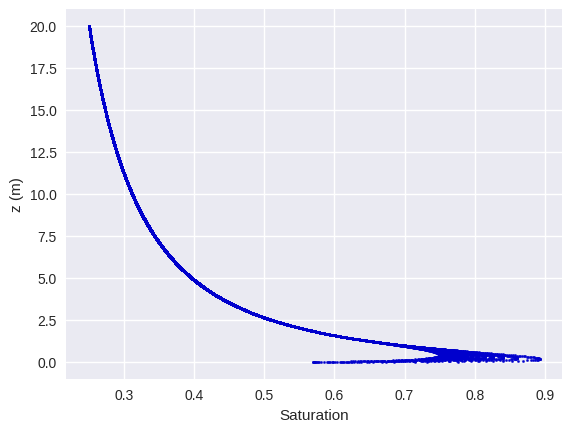

In [10]:
plt.figure()
plt.style.use('seaborn')

plt.scatter(saturation_profile_REF.sat,saturation_profile_REF.z, s=10, alpha=1, color='mediumblue',marker='.')
plt.xlabel('Saturation')
plt.xlabel('Saturation')
plt.ylabel('z (m)')
plt.show()